In [0]:
import os

req_folders = ['./content/pictures', './content/artwork', './content/output']

!rm -rf ./content/artwork
!rm -rf ./content/pictures

for folder in req_folders:
  if not os.path.exists(folder):
    os.makedirs(folder)
    
!wget --quiet -P ./content/pictures/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P ./content/artwork/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P ./content/artwork/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
!wget --quiet -O ./content/artwork/Picasso_Figure.jpg -P ./content/artwork/ https://upload.wikimedia.org/wikipedia/en/8/8f/Pablo_Picasso%2C_1909-10%2C_Figure_dans_un_Fauteuil_%28Seated_Nude%2C_Femme_nue_assise%29%2C_oil_on_canvas%2C_92.1_x_73_cm%2C_Tate_Modern%2C_London.jpg
!wget --quiet -P ./content/artwork/ https://upload.wikimedia.org/wikipedia/commons/e/ea/Monet_Painting_on_His_Studio_Boat_Edouard_Manet_1874.jpg
!wget --quiet -O ./content/artwork/van_gogh.jpg -P ./content/artwork/ https://upload.wikimedia.org/wikipedia/commons/thumb/9/94/Starry_Night_Over_the_Rhone.jpg/774px-Starry_Night_Over_the_Rhone.jpg
!wget --quiet -O ./content/pictures/alma.jpg -P ./content/pictures/ https://upload.wikimedia.org/wikipedia/commons/f/ff/2014_Columbia_University_Alma_Mater.jpg
!wget --quiet -O ./content/pictures/steps.jpg -P ./content/pictures/ https://static01.nyt.com/images/2016/05/17/business/18xp-knight/18xp-knight-superJumbo.jpg  

In [0]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import IPython

from tensorflow.python.keras.preprocessing import image as pre
from tensorflow.python.keras import models 
from tensorflow.python.keras import backend as K
import cv2
import scipy as sp

In [0]:
tf.enable_eager_execution()

content_path = './content/pictures/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = './content/artwork/Picasso_Figure.jpg'

ARTWORK_FOLDER = "./content/artwork"
PICTURE_FOLDER = "./content/pictures"
OUTPUT_FOLDER = "./content/output"

MAX_DIM = 512

# For de-processing processed images
CHANNEL_MEANS = np.array([103.939, 116.779, 123.68])

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

UPDATE_EPOCH = 200

In [0]:
def load_image(image_file):
    ''' Function that loads an image from an input file path.
    The function will return a numpy array that represents the
    pixel values of the image.'''
    
    # Get the image and a scaling factor
    image = Image.open(image_file)
    image_scale = MAX_DIM / max(image.size)

    # Resize the image according to the scale and get it in array form
    image = image.resize((round(image.size[0] * image_scale), round(image.size[1] * image_scale)), Image.ANTIALIAS)
    image = pre.img_to_array(image)

    # Add a dimension in the 0th axis to account for the batch size
    image = np.expand_dims(image, axis = 0)
    
    return image


def deprocess_image(processed_image):
    ''' Function that de-processes the image after it finishes
    a forward pass of the neural model. This processing includes
    shifting the pixel values by the normalized mean and
    removing the "batch" dimension. '''

    # remove the "batch" dimension from the image
    image = processed_image.copy()
    if len(image.shape) == 4:
        image = np.squeeze(image, axis = 0)

    # This reverses the process of tf.keras.applications.vgg19.preprocess_input
    image[:, :, 0] += CHANNEL_MEANS[0]
    image[:, :, 1] += CHANNEL_MEANS[1]
    image[:, :, 2] += CHANNEL_MEANS[2]
    image = image[:, :, ::-1]

    # ensure pixel values are within 
    image = np.clip(image, 0, 255).astype('uint8')
    return image

def imshow(image):

    # Remove the batch dimension
    image = np.squeeze(image, axis = 0)
    plt.imshow(image.astype('uint8'))

In [0]:
def model():
    ''' Function that returns a neural network model derived from the Imagenet
    VGG19 model. The inputs of the model are the same as that of the VGG19
    model, however, the outputs are the feature representations of the input
    at the specified layers in config.py. '''

    # get the original model
    original_vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')

    # specify the outputs
    content_outputs = [original_vgg.get_layer(layer).output for layer in content_layers]
    style_outputs = [original_vgg.get_layer(layer).output for layer in style_layers]

    # return the custom model
    return models.Model(original_vgg.input, content_outputs + style_outputs)


def gram_matrix(feature):
    ''' Based on the implementation described in
    https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
    '''
    # flatten the features to one column per channel
    num_channels = feature.shape[-1]
    feature = tf.reshape(feature, (-1, num_channels))

    return tf.matmul(feature, feature, transpose_a = True)


def gram_style_loss(predicted_gram, actual_gram, pixels, channels):
    ''' Based on the implementation described in
    https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
    '''
    loss_ = tf.reduce_sum(tf.square(predicted_gram - actual_gram))
    return loss_ / (4 * (pixels ** 2) * (channels ** 2))


def content_loss(predicted, actual):
    ''' Based on the implementation described in
    https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
    '''
    return 0.5 * tf.reduce_sum(tf.square(predicted - actual))


def loss(model, output_image, actual_content_features, actual_gram_features, alpha = 10000, beta = 1):
    ''' Function that computes the total loss for the current iteration of the gradient descent
    algorithm. The loss function is based on the implementation described in
    https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
    The function returns a linear combination of the content and style loss based on the multipliers
    (alpha and beta) specified. '''

    # get the content and style representations
    model_representation = model(output_image)
    content_representation = model_representation[ : len(content_layers)]
    style_representation = model_representation[len(content_layers) : ]

    # initialize loss counters
    total_content_loss, total_style_loss = 0, 0

    # for every content representation, get the loss
    for actual_content, predicted_content in zip(actual_content_features, content_representation):
        total_content_loss += content_loss(predicted_content, actual_content)

    # for every style representation, get the loss for the corresponding gram matrix
    for actual_gram, predicted_style in zip(actual_gram_features, style_representation):
        predicted_gram = gram_matrix(predicted_style)
        shape = tf.shape(predicted_style)
        total_style_loss += gram_style_loss(predicted_gram, actual_gram, float(shape[0] * shape[1]), float(shape[-1]))

    # normalize loss per layer
    total_content_loss /= len(content_layers)
    total_style_loss /= len(style_layers)

    # return total loss based on the linear combination
    loss_ = (alpha * total_content_loss) + (beta * total_style_loss)
    return loss_


def feature_representations(model, content_image, style_image):
    ''' Function that returns the feature representations of a
    content and style image.'''

    content = model(content_image)
    style = model(style_image)

    content_features = [layer for layer in content[ : len(content_layers)]]
    style_features = [layer for layer in style[len(content_layers) : ]]

    return content_features, style_features

In [0]:
def loss_and_gradients(my_model, output_image, content_features, gram_style_features, alpha = 10000, beta = 1):
    ''' Function that computes the gradients for the output image based on the actual content and style
    features as well as their respective multipliers. '''
    with tf.GradientTape() as g:
        loss_ = loss(my_model, output_image, content_features, gram_style_features, alpha, beta)
    return loss_, g.gradient(loss_, output_image)


def transfer_style(content_image, style_image, epochs = 10000, alpha = 10000, beta = 1):
    ''' Function that transfers the style from the content_image to the style_image. 
    The gradient descent algorithm is performed over 'epochs' iterations and the 
    multiplier for the content and style are specified by alpha and beta respectively. '''

    # get the model
    my_model = model()
    for layer in my_model.layers:
        layer.trainable = False

    # get the actual content and style representations
    content_features, style_features = feature_representations(my_model, content_image, style_image)
    gram_style_features = [gram_matrix(feature) for feature in style_features]

    # create a random noise image
    output_image = np.random.randint(0, 256, size = content_image.shape).astype('float32')
    output_image = tf.keras.applications.vgg19.preprocess_input(output_image)
    output_image = tfe.Variable(output_image, dtype=tf.float32)

    # create tracking variables and the Adam optimizer
    counter, min_loss, best_image = 1, float('inf'), None
    optimizer = tf.train.AdamOptimizer(5, beta1=0.99, epsilon=0.1)

    # set the minimum and maximum values allowed in the image accounting for channel means
    minimum, maximum = - CHANNEL_MEANS, 255 - CHANNEL_MEANS

    # start the timer
    start_time = time.time()
    update_start_time = time.time()

    for i in range(epochs):

        # get the loss and gradients for the output image based on the current iteration
        loss_, curr_gradients = loss_and_gradients(my_model, output_image, content_features, gram_style_features, alpha, beta)

        # apply the gradients based on the current loss
        optimizer.apply_gradients([(curr_gradients, output_image)])

        # clip the new matrix based on the minimum and maximum values
        output_image.assign(tf.clip_by_value(output_image, minimum, maximum))

        # if a new best image is found
        if loss_ < min_loss:
            min_loss = loss_
            best_image = output_image.numpy()

        # print loss and time statistics after every UPDATE_EPOCH iterations
        if i % UPDATE_EPOCH == 0:
          
            plot_img = output_image.numpy()
            plot_img = deprocess_image(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))

            print("Iteration: {} \t Total Loss: {}".format(i, loss_))
            print("Time for {} epochs = {} seconds.".format(UPDATE_EPOCH, time.time() - update_start_time))
            update_start_time = time.time()

    # print the total time taken to perform the optimization algorithm
    print("\nTotal Time: {} seconds".format(time.time() - start_time))

    # return the best found image and the associated overall loss
    return deprocess_image(best_image), min_loss

In [0]:
def color_transfer(source, target):
    # convert color space from BGR to L*a*b color space
    # note - OpenCV expects a 32bit float rather than 64bit
    source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB).astype("float32")
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB).astype("float32")
    # compute color stats for both images
    (smean, scov) = image_stats(source)
    (tmean, tcov) = image_stats(target)
    
    print(smean)
    print(scov)
    print(tmean)
    print(tcov)
    
    # cholesky
    w_s,v_s = np.linalg.eig(scov)
    eig_s = sp.linalg.sqrtm(np.diag(w_s))
    w_t,v_t = np.linalg.eig(tcov)
    eig_t = sp.linalg.sqrtm(np.diag(w_t))
    
    s_root = np.matmul(v_s, eig_s)
    s_root = np.matmul(s_root, v_s.transpose())
    t_root = np.matmul(v_t, eig_t)
    t_root = np.matmul(t_root, v_t.transpose())
    t_inv = np.linalg.inv(t_root)
    
    A = np.matmul(s_root, t_inv)
    print(A)
    b_act = smean - (np.matmul(A, tmean))
    print(b_act)
    
    (r, g, b) = cv2.split(target)
    new_img = target.copy()
    
    m,n = r.shape
    for x in range(m):
      for y in range(n):
        x_val = np.matrix([[r[x][y], g[x][y], b[x][y]]]).transpose()
        x_new = np.matmul(A, x_val) + b_act
        new_img[x][y][0] = x_new[0][0]
        new_img[x][y][1] = x_new[1][0]
        new_img[x][y][2] = x_new[2][0]
    
    
    # converting back to BGR
    transfer = cv2.cvtColor(new_img.astype("uint8"), cv2.COLOR_RGB2BGR)
    return transfer

In [0]:
def image_stats(image):
    # compute mean and standard deviation of each channel
    (r, g, b) = cv2.split(image)
    
    rMean = np.average(r)
    gMean = np.average(g)
    bMean = np.average(b)
    mean = np.matrix([[rMean, gMean, bMean]]).transpose()
    cov = np.matrix([[0.0, 0.0, 0.0],[0.0,0.0,0.0],[0.0,0.0,0.0]])
    m,n = r.shape
    for x in range(m):
      for y in range(n):
        x_val = np.matrix([[r[x][y], g[x][y], b[x][y]]]).transpose()
        temp_one = (x_val - mean)
        temp_two = np.matrix(temp_one).transpose()
        sum_val = ((np.matmul(temp_one, temp_two)) / (m*n))
        cov += sum_val

    return (mean, cov)

In [0]:
def show_image(title, image, width=720):
    r = width/float(image.shape[1])
    dim = (width, int(image.shape[0]*r))
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    print("show images")
    cv2.imshow(title, resized)

[[150.71756]
 [140.07959]
 [128.70993]]
[[6583.82192211 5888.6718881  5738.19833951]
 [5888.6718881  5544.2971061  5386.24411736]
 [5738.19833951 5386.24411736 5600.06956037]]
[[ 56.729053]
 [ 87.0728  ]
 [101.93672 ]]
[[2038.12001143 1913.51352448 1276.77396831]
 [1913.51352448 2108.98420167 1787.10238095]
 [1276.77396831 1787.10238095 2248.57193502]]
[[ 1.82076633 -0.61378892  0.78436723]
 [ 0.34764941  1.04852103  0.29855533]
 [ 0.92712897 -0.33503644  1.22390737]]
[[ 20.91570498]
 [ -1.37364502]
 [-19.4737625 ]]


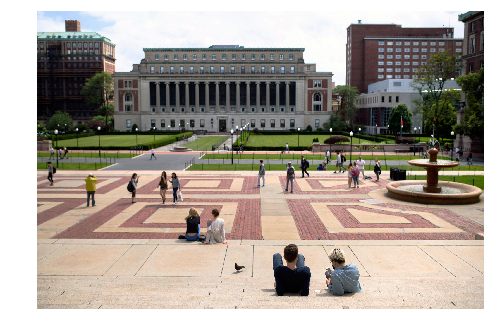

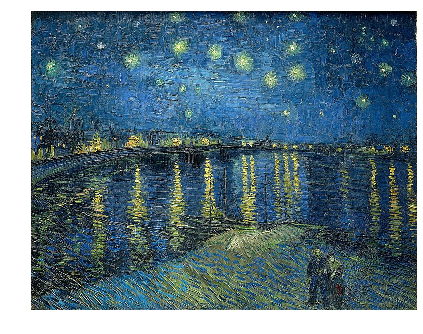

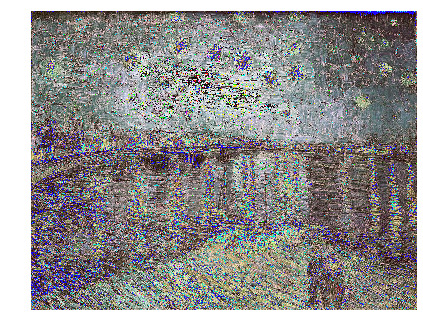

In [11]:
target = cv2.imread('./content/artwork/van_gogh.jpg')
source = cv2.imread('./content/pictures/steps.jpg')

# transfer of color
transfer = color_transfer(source, target)

# display of image
img = plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB)); 
img.set_cmap('hot')
plt.axis('off')
plt.show()
img = plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB)); 
img.set_cmap('hot')
plt.axis('off')
plt.show()
img = plt.imshow(cv2.cvtColor(transfer, cv2.COLOR_BGR2RGB)); 
img.set_cmap('hot')
plt.axis('off')
plt.show()

im = Image.fromarray(transfer)
new_style_path = './content/pictures/transfer.jpeg'
im.save(new_style_path)

In [12]:
source = cv2.imread('./content/pictures/steps.jpg')
target = cv2.imread('./content/output/output-1544018765.6386755.jpg')

# transfer of color
transfer = color_transfer(source, target)

# display of image
img = plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB)); 
img.set_cmap('hot')
plt.axis('off')
plt.show()
img = plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB)); 
img.set_cmap('hot')
plt.axis('off')
plt.show()
img = plt.imshow(cv2.cvtColor(transfer, cv2.COLOR_BGR2RGB)); 
img.set_cmap('hot')
plt.axis('off')
plt.show()

im = Image.fromarray(transfer)
new_style_path = './content/pictures/transfer_fin.jpeg'
im.save(new_style_path)

error: ignored

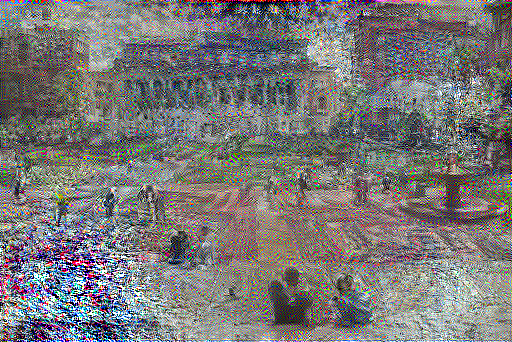

Iteration: 9800 	 Total Loss: 592796647424.0
Time for 200 epochs = 51.28586435317993 seconds.

Total Time: 2567.069623231888 seconds


In [13]:
content_image = load_image('./content/pictures/steps.jpg')
style_image = load_image('./content/pictures/transfer.jpeg')

content_image = tf.keras.applications.vgg19.preprocess_input(content_image).astype('float32')
style_image = tf.keras.applications.vgg19.preprocess_input(style_image).astype('float32')

print("Loaded the images...")
print("Starting style transfer...")
output_image, mis_loss = transfer_style(content_image, style_image)
im = Image.fromarray(output_image)
im.save(OUTPUT_FOLDER + '/' + 'output-' + str(time.time()) + '.jpg')

In [0]:
im.save(OUTPUT_FOLDER + '/' + 'output-.jpg')